In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from yellowbrick.regressor import AlphaSelection
from sklearn.linear_model import LassoCV

%matplotlib inline
sns.set_style('white')

C:\Users\Omistaja\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


This dataset named 'adult' chosen for this assignment and the description can be found in the UCI machine learning repository linked below. 

The dataset contains 16 columns. The target filed is Income. It is divide into two classes: <=50K and >50K. Using the other variables such as individual’s education level, age, gender, occupation, etc, we will build three different Logistics Regression models (Vanilla, Ridge, Lasso) to estimate the income and compare the models. 

http://www.cs.toronto.edu/~delve/data/adult/desc.html

http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

## Data Exploration and Preparation

In [2]:
adult = pd.read_csv('adult.csv')#, header=0)
adult.head()


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
adult.columns = ['Age', 'Work_class', 'Final_weight', 'Education', 'Education_num', 'Marital_status', 'Occupation', 'Relationship', 'Race',
              'Sex', 'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Native_country', 'Income_group']

In [4]:
# Represent the dependent variable with binary digits
adult['Income_group'] = adult.Income_group.str.replace('<=50K','0')
adult['Income_group'] = adult.Income_group.str.replace('>50K','1')

In [5]:
adult.head()

,Age,Work_class,Final_weight,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income_group
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0


In [6]:
adult['Income_group'].value_counts()

0    37155
1    11687
Name: Income_group, dtype: int64

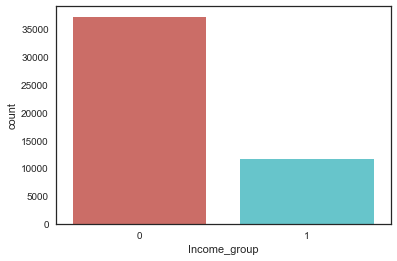

In [7]:
sns.countplot(x='Income_group', data=adult, palette='hls')
plt.show()

There are 37, 155 people who earn 50K or less per year and 11, 687 who earn more than 50K.

In [8]:
adult.groupby('Income_group').mean()

,Age,Final_weight,Education_num,Capital_gain,Capital_loss,Hours_per_week
Income_group,,,,,,
0,36.872184,190039.565523,9.598493,147.010308,54.151931,38.840048
1,44.275178,188470.574570,11.602807,4042.239497,193.528964,45.452896


The continious variables above show variability for the two income groups and hence look good predictors of the outcome variable. 

The data seems to have no missing values at first sight but a closer look at some of the columns reveals that some values are represented with the symbol '?'

In [9]:
adult.isnull().sum() # no NaN values

Age               0
Work_class        0
Final_weight      0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income_group      0
dtype: int64

In [10]:
# Missing values are represented with '?' 
adult['Work_class'].unique() 

array(['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [11]:
# Replace missing values with NaN
adult = adult.replace('?', np.nan)

In [12]:
# Now we can see and deal with Nan values in the dataframe 
adult.isnull().sum()

Age                  0
Work_class        2799
Final_weight         0
Education            0
Education_num        0
Marital_status       0
Occupation        2809
Relationship         0
Race                 0
Sex                  0
Capital_gain         0
Capital_loss         0
Hours_per_week       0
Native_country     857
Income_group         0
dtype: int64

In [13]:
#Let's go ahead and drop the NaN values 
adult = adult.dropna()

Some of the categorical variables have many closely defined categories. let's examine them and group them for a better modeling. 

In [14]:
#Examine categories 
adult['Work_class'].unique() 

array(['Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay'], dtype=object)

Let's group Loval-gov, Federal-gov, and State-gov together as gov, Self-emp-not-inc, and 'Self-emp-inc' as 'Self_employed

In [15]:
# Combine similar categories 
adult['Work_class']=np.where(adult['Work_class'] =='Local-gov', 'Gov', adult['Work_class'])
adult['Work_class']=np.where(adult['Work_class'] =='Federal-gov', 'Gov', adult['Work_class'])
adult['Work_class']=np.where(adult['Work_class'] =='State-gov', 'Gov', adult['Work_class'])
adult['Work_class']=np.where(adult['Work_class'] =='Self-emp-not-inc', 'Self_employed', adult['Work_class'])
adult['Work_class']=np.where(adult['Work_class'] =='Self-emp-inc', 'Self_employed', adult['Work_class'])


Do the same for Education catgories. Group pre high school levels together as 'Some-school'. 

Education level is a good variable to predict our outcome variable. 

In [16]:
# Chech categories 
adult['Education'].unique()

array(['11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th',
       'Prof-school', '7th-8th', 'Bachelors', 'Masters', '5th-6th',
       'Assoc-voc', '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'],
      dtype=object)

In [17]:
#Combine similar categories 
adult['Education']=np.where(adult['Education'] == '11th', 'Some-school', adult['Education'])
adult['Education']=np.where(adult['Education'] == '10th', 'Some-school', adult['Education'])
adult['Education']=np.where(adult['Education'] == '7th-8th', 'Some-school', adult['Education'])
adult['Education']=np.where(adult['Education'] == '5th-6th', 'Some-school', adult['Education'])
adult['Education']=np.where(adult['Education'] == '9th', 'Some-school', adult['Education'])
adult['Education']=np.where(adult['Education'] == '12th', 'Some-school', adult['Education'])
adult['Education']=np.where(adult['Education'] == '1st-4th', 'Some-school', adult['Education'])
adult['Education']=np.where(adult['Education'] == 'Preschool', 'Some-school', adult['Education'])

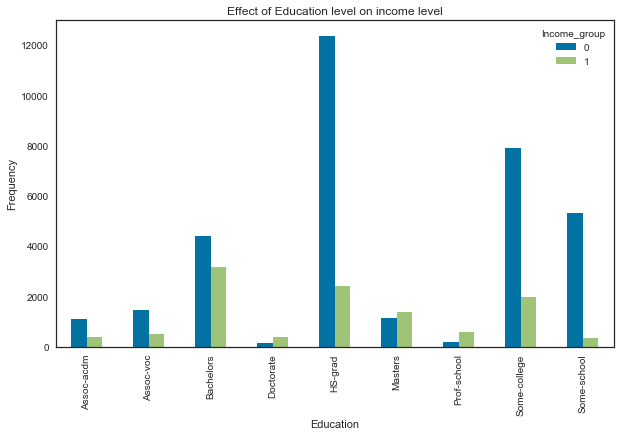

In [18]:
# Visulaize the role of education on income level
pd.crosstab(adult.Education,adult.Income_group).plot(kind='bar', figsize=(10,6))
plt.title('Effect of Education level on income level')
plt.xlabel('Education')
plt.ylabel('Frequency')
plt.show()

'Husband' and 'Wife' can be grouped as 'Married'

In [19]:
# Check categories
adult['Relationship'].unique()

array(['Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife',
       'Other-relative'], dtype=object)

In [20]:
#Combine 'Husband' and 'Wife' as 'Married'. 
adult['Relationship']=np.where(adult['Relationship'] == 'Husband', 'Married', adult['Relationship'])
adult['Relationship']=np.where(adult['Relationship'] == 'Wife', 'Married', adult['Relationship'])

The Native Country category has a lot of countries in it. We can reduce it by grouping them based on their geo-economic locations. We expect the income levels in US and Canada to be higher than the rest of their geographic nighbours and as a result we will group them separately. The same argument applies to East and West European countries. 

In [21]:
adult['Native_country'].unique()

array(['United-States', 'Peru', 'Guatemala', 'Mexico',
       'Dominican-Republic', 'Ireland', 'Germany', 'Philippines',
       'Thailand', 'Haiti', 'El-Salvador', 'Puerto-Rico', 'Vietnam',
       'South', 'Columbia', 'Japan', 'India', 'Cambodia', 'Poland',
       'Laos', 'England', 'Cuba', 'Taiwan', 'Italy', 'Canada', 'Portugal',
       'China', 'Nicaragua', 'Honduras', 'Iran', 'Scotland', 'Jamaica',
       'Ecuador', 'Yugoslavia', 'Hungary', 'Hong', 'Greece',
       'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc)', 'France',
       'Holand-Netherlands'], dtype=object)

In [22]:
adult['Native_country'] = adult['Native_country'].replace(['United-States', 'Canada'], 'North-America')
adult['Native_country'] = adult['Native_country'].replace(['Peru','Columbia', 'Ecuador', 'Cuba', 'Dominican-Republic', 'El-Salvador', 'Guatemala',
                   'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua',
                   'Outlying-US(Guam-USVI-etc)', 'Puerto-Rico', 'Trinadad&Tobago'], 'Other-Americas')
adult['Native_country'] = adult['Native_country'].replace(['Hungary', 'Poland', 'Yugoslavia'], 'East-Europe')
adult['Native_country'] = adult['Native_country'].replace(['England', 'France', 'Germany', 'Holand-Netherlands', 'Greece', 'Ireland', 'Italy','Portugal','Scotland'], 'West-Europe')
adult['Native_country'] = adult['Native_country'].replace(['Philippines', 'Thailand', 'Vietnam', 'Japan', 'India', 'Cambodia','Laos', 'Taiwan', 'China',
                                                           'Iran', 'Hong'])
adult['Native_country'] = adult['Native_country'].replace('South', 'Other')

There is a difference in income levels of each region and hence it is a good predictor of our outcome variable. 

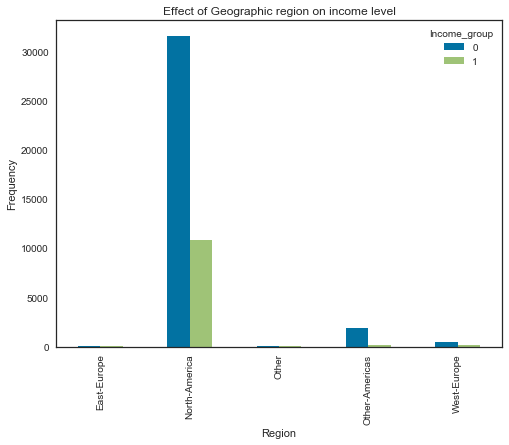

In [23]:
# Visulaize the role of education on income level
pd.crosstab(adult.Native_country,adult.Income_group).plot(kind='bar', figsize=(8,6))
plt.title('Effect of Geographic region on income level')
plt.xlabel('Region')
plt.ylabel('Frequency')
plt.show()

### Create Dummy Variables

In [24]:
# Get dummies for catagorical variables 
pd.get_dummies(adult).head()

,Age,Final_weight,Education_num,Capital_gain,Capital_loss,Hours_per_week,Work_class_Gov,Work_class_Private,Work_class_Self_employed,Work_class_Without-pay,...,Race_White,Sex_Female,Sex_Male,Native_country_East-Europe,Native_country_North-America,Native_country_Other,Native_country_Other-Americas,Native_country_West-Europe,Income_group_0,Income_group_1
0,25,226802,7,0,0,40,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
1,38,89814,9,0,0,50,0,1,0,0,...,1,0,1,0,1,0,0,0,1,0
2,28,336951,12,0,0,40,1,0,0,0,...,1,0,1,0,1,0,0,0,0,1
3,44,160323,10,7688,0,40,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
5,34,198693,6,0,0,30,0,1,0,0,...,1,0,1,0,1,0,0,0,1,0


In [25]:
adult['Income_group'] = pd.to_numeric(adult['Income_group'], errors='coerce')

In [26]:
# Define dependent and independent variables 
X = adult.drop('Income_group', 1)
Y = adult['Income_group']
X = pd.get_dummies(X)

## Build the Models

### 1. Vanilla logistic regression

In [27]:
# Standardize the features 
X_std = StandardScaler().fit_transform(X)

In [28]:
# Split the data and fit to the model 
X_train, X_test, y_train, y_test = train_test_split(X_std, Y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_ = logreg.predict(X_test)
# Ten fold cross validation score to evaluate the model 
score_logreg = cross_val_score(logreg, X_std, Y, cv=10)
print(score_logreg)


[0.8470042  0.84236126 0.84523546 0.84413    0.84321097 0.84188412
 0.85139319 0.84630694 0.8562265  0.84914842]


In [29]:
# Print Confusion matrix
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(y_test, Y_)
print('confusion_matrix')
print(cfm)

confusion_matrix
[[9364  778]
 [1400 2025]]


We have 11389 correct predictions(9364 + 2025) and 2178 incorrect predictions (1400 + 778)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, Y_))

             precision    recall  f1-score   support

          0       0.87      0.92      0.90     10142
          1       0.72      0.59      0.65      3425

avg / total       0.83      0.84      0.83     13567



From the entire test set, correct category was predicted with a precision of 83%. The F1-score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important. Inour case recall is more relevant. 

### 2. Ridge logistic regression

In [31]:
# Split the data 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_std, Y, test_size=0.3, random_state=0)

### Setting the regularization parameter with RidgeCV

In [32]:
#Setting the regularization parameter 
from sklearn import linear_model
#reg = linear_model.RidgeCV(alphas=[0.001, 0.1, 0.5, 0.25, 75, .80, 1, 2, .01])
reg = linear_model.RidgeCV(alphas = np.arange(.2, 10, 1), normalize=True)
reg.fit(X_train2, y_train2)
#np.arange(3,7,2)

RidgeCV(alphas=array([0.2, 1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2, 9.2]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=True,
    scoring=None, store_cv_values=False)

In [33]:
reg.alpha_ 


0.2

Ridge classifier with the alpha value from RidgeCV above gives a score of about 72%

In [34]:
rdgc = RidgeClassifier(alpha=.2, fit_intercept=False)
fit_rdgc = rdgc.fit(X_train2, y_train2)
Y2_ = fit_rdgc.predict(X_test2)

#Cross validation score
rdgc_cv = cross_val_score(fit_rdgc, X_train2, y_train2, cv=10)
print(rdgc_cv)

[0.72276602 0.72876539 0.71415035 0.72796209 0.72132701 0.7150079
 0.71943128 0.70363349 0.72322275 0.72511848]


In [35]:
print('Average score', rdgc_cv.mean())

Average score 0.7201384766766846


The ridge classifier gives a much better score with the default alpha as shown below. 


In [36]:
rdgc_default = RidgeClassifier()
fit_rdgc_default = rdgc_default.fit(X_train2, y_train2)
Y2_d = fit_rdgc_default.predict(X_test2)

#Cross validation score
rdgc_default = cross_val_score(fit_rdgc_default, X_train2, y_train2, cv=10)
print(rdgc_default)

[0.83422798 0.83391222 0.84301958 0.83507109 0.82969984 0.83412322
 0.85308057 0.83064771 0.83159558 0.83096367]


In [37]:
print('Average score', rdgc_default.mean() * 100)

Average score 83.56341453404548


In [38]:
#Confusion matrix
cfm_ridge = confusion_matrix(y_test2, Y2_d)
print('Confusion Matrix ridge')
print(cfm_ridge)

Confusion Matrix ridge
[[9528  614]
 [1704 1721]]


We have 11249 correct predictions(9528+1721) and 2318 incorrect predictions (614+1704) Which is slightly lower than the vanila logistrics regression above. 

In [39]:
print('Classification report')
print(classification_report(y_test2, Y2_d))

Classification report
             precision    recall  f1-score   support

          0       0.85      0.94      0.89     10142
          1       0.74      0.50      0.60      3425

avg / total       0.82      0.83      0.82     13567



From the entire test set, correct category was predicted with a precision of 82%. The F1-score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important. Inour case recall is more relevant.

### 2. Lasso logistic regression

### Setting the regularization parameter for Lasso

This is an attept to use AlphaSelection module of Yellowbrick library. The result is a value of 0.00.


In [40]:
# Split the data and fit to the model 
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_std, Y, test_size=0.3, random_state=0)
lasso = LogisticRegression(penalty='l1')
lasso.fit(X_train3, y_train3)

Y_Lasso = lasso.predict(X_test3)
# Cross validation score to evaluate the model 
score_lasso = cross_val_score(lasso, X_std, Y, cv=10)
print(score_lasso)

[0.8470042  0.84214017 0.84523546 0.84413    0.84298983 0.84210526
 0.85139319 0.84652808 0.8562265  0.84914842]


In [41]:
print('Average score', score_lasso.mean() * 100)

Average score 84.6690112009696


The Lasso classification model gives a more accurate prediction than the vanilla and ridge regression models. 

In [42]:
#Confusion matrix
cfm_lasso = confusion_matrix(y_test3, Y_Lasso)
print('Confusion Matrix ridge')
print(cfm_lasso)

Confusion Matrix ridge
[[9364  778]
 [1400 2025]]


We have 11389 correct predictions(9364+2025) and 2178 incorrect predictions (778+1400) Which is better than the vanila  and ridge logistrics classification models above. 

In general, the ridge and vanilla models seem to perform with only a little difference in their accuracy while the classification model using lasso model gives a better accuracy than the other two. 